In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import msprime as msp
import pandas as pd

import statsmodels.api as sm
lowess = sm.nonparametric.lowess

import os
import sys
sys.path.append('../../src/')
from draw_demography import *
from plot_utils import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.autolayout'] = True
from mpl_toolkits.axes_grid1 import make_axes_locatable

main_figdir = '../../plots/hap_copying/'
supp_figdir = '../../plots/supp_figs/hap_copying/'
os.makedirs(main_figdir, exist_ok=True)
os.makedirs(supp_figdir, exist_ok=True)

In [3]:
# Reading in the CSV with all of the simulation results
hap_copy_sim_df = pd.read_csv('../../results/hap_copying/simulations/jump_rate_est_sims.csv')
hap_copy_sim_df.head()

,scenario,Ne,scale_marginal,se_scale_marginal,se_scale_marginal_fd,scale_jt,eps_jt,se_scale_jt,se_eps_jt,n_panel,n_snps,ta,min_maf,seed
0,SerialConstant,20000,1425.139220,6.521708,6.487378,1000.158749,0.004726,42.592458,0.000034,100.0,199066.0,20.0,1,1
1,SerialConstant,20000,1257.158092,6.068907,6.077972,1000.097638,0.004175,30.762464,0.000035,100.0,199066.0,40.0,1,1
2,SerialConstant,20000,1131.697909,5.691320,5.707964,1000.050826,0.003479,20.526857,0.000028,100.0,199066.0,60.0,1,1
3,SerialConstant,20000,1396.956127,6.485220,6.455229,1000.191450,0.005472,42.799067,0.000036,100.0,199066.0,80.0,1,1
4,SerialConstant,20000,1302.845259,6.185797,6.181666,1000.108167,0.004269,33.093261,0.000037,100.0,199066.0,100.0,1,1


In [4]:
def plot_bot_demo(ax, N0=1e4, T_bot=100, b=0.1, **kwargs):
    """Plot bottleneck demography
    """
    xs = np.arange(0, int(10*T_bot))
    ns = np.repeat(N0, xs.size)
    ns[T_bot:] = N0*b
    ax.plot(xs,ns, **kwargs)
    
from scipy.stats import linregress 
def split_regression(x,y,split=400):
    """Perform linear regression using datapoints split on X (pre-post bottleneck)
    """
    idx = (x < split)
    return(linregress(x[idx], y[idx]), linregress(x[~idx],y[~idx]))

def rand_jitter(arr, seed=42):
    """Randomized jitter for a value."""
    np.random.seed(seed);
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

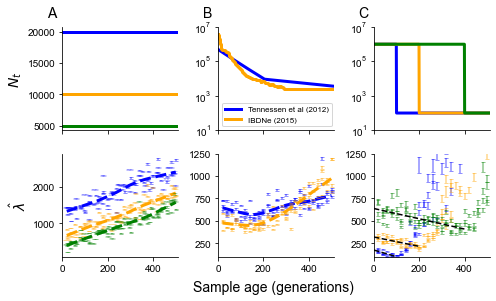

In [5]:
# Generating a finalized figure 
fig, axs = plt.subplots(2,3, figsize=(7,4), 
                        sharex='col', tight_layout=True)

Nes = [20000, 10000, 5000]
# Plotting the constants
colors=['blue', 'orange', 'green']
i = 0
for n in Nes:
    axs[0,0].axhline(n, color=colors[i], lw=3)
    filt_df = hap_copy_sim_df[(hap_copy_sim_df.scenario == 'SerialConstant') & (hap_copy_sim_df.Ne == n)]
    # NOTE : we should plot these with error bars and some jitter?
#     axs[0,1].scatter(filt_df['ta'].values, filt_df['scale_marginal'].values, color=colors[i], s=10)
    axs[1,0].errorbar(rand_jitter(filt_df['ta'].values), 
                     filt_df['scale_marginal'].values, 
                     yerr=2*filt_df['se_scale_marginal_fd'].values,
                     capsize=2, color=colors[i], linestyle='none', alpha=0.25)
    
    z = lowess(filt_df['scale_marginal'].values, filt_df['ta'].values, frac=1/2)
    axs[1,0].plot(z[:,0], z[:,1], color=colors[i], lw=3, linestyle='--')
    
    axs[0,0].set_xlim(0,510)
    i += 1
    
    
# Plotting the tennessen and IBDNE demography
tennessen_df = hap_copy_sim_df[(hap_copy_sim_df.scenario == 'TennessenEuropean')]
ibdne_uk10k_df = hap_copy_sim_df[hap_copy_sim_df.scenario == 'IBDNeUK10K']

axs[1,1].errorbar(tennessen_df['ta'].values, 
                  tennessen_df['scale_marginal'].values, 
                  yerr=2*tennessen_df['se_scale_marginal_fd'], 
                  capsize=2, color=colors[0], linestyle='none', alpha=0.25)

z = lowess(tennessen_df['scale_marginal'].values, tennessen_df['ta'].values, frac=1/2)
axs[1,1].plot(z[:,0], z[:,1], color=colors[0], lw=3, linestyle='--')


axs[1,1].errorbar(ibdne_uk10k_df['ta'].values, 
                  ibdne_uk10k_df['scale_marginal'].values, 
                  yerr=2*ibdne_uk10k_df['se_scale_marginal_fd'], 
                  capsize=2, color=colors[1], linestyle='none', alpha=0.25)

z = lowess(ibdne_uk10k_df['scale_marginal'].values, ibdne_uk10k_df['ta'].values, frac=1/2)
axs[1,1].plot(z[:,0], z[:,1], color=colors[1], lw=3, linestyle='--')

demo_model1_file = {'Tennessen et al (2012)': '../../data/demo_models/tennessen_european.txt', 
                    'IBDNe (2015)': '../../data/demo_models/uk10k.IBDNe.txt'}
i = 0
for x in demo_model1_file:
    _,demo = read_demography(demo_model1_file[x])
    t,nt = generate_demography(demo)
    axs[0,1].plot(t,nt,lw=3,label=x, color=colors[i])
    i += 1
axs[0,1].set_yscale('log')
axs[0,1].set_ylim(1e1,1e7)
axs[0,1].set_xlim(0,510)
axs[0,1].legend(fontsize=8)
    

# Plotting the instant bottlenecks
n_bot = 0.0001
t_bot = [100,200,400]
nuniq = np.unique(t_bot).size
i = 0
scenarios = ['SerialBottleneckInstant7', 'SerialBottleneckInstant8', 'SerialBottleneckInstant9']
for t in np.unique(t_bot):
    x = scenarios[i]
    filt_instant_bot_df = hap_copy_sim_df[hap_copy_sim_df.scenario == x]
    reg_res_pre_bot, reg_res_post_bot = split_regression(filt_instant_bot_df.ta, filt_instant_bot_df.scale_jt, split=t)
    
    # Plot separately in case things blow up...
    idx = (filt_instant_bot_df.ta < t)
    axs[1,2].errorbar(filt_instant_bot_df.ta.values[idx], 
                      filt_instant_bot_df.scale_jt.values[idx], 
                      yerr=2*filt_instant_bot_df.se_scale_marginal_fd.values[idx],
                      color=colors[i], linestyle='none', capsize=2, alpha=0.25)
    axs[1,2].errorbar(filt_instant_bot_df.ta.values[~idx], filt_instant_bot_df.scale_jt.values[~idx],
                      yerr=2*filt_instant_bot_df.se_scale_marginal_fd.values[~idx], 
                      linestyle='none', capsize=2, color=colors[i], alpha=0.25)
    
    
    beta = reg_res_pre_bot.slope
    x_test_pre_bot = np.arange(0,t)
    y_test_pre_bot = reg_res_pre_bot.slope*x_test_pre_bot + reg_res_pre_bot.intercept
    axs[1,2].plot(x_test_pre_bot, y_test_pre_bot, linestyle='--', color='black')
    
    plot_bot_demo(axs[0,2], T_bot=t, N0=1000000, b=n_bot, color=colors[i], lw=3)
    i += 1
    
axs[0,2].set_xlim(0,510)
axs[0,2].set_ylim(1e1,1e7)
axs[1,2].set_ylim(1e1,1e3)
axs[0,2].set_yscale('log')


axs[1,1].set_ylim(100,1250)
axs[1,2].set_ylim(100,1250)


# Debox all of these plots
for ax in axs:
    debox_all(ax)

# Label the multiple panels
label_multipanel(axs[0,:], ['A','B','C'], yoff=1.2, fontsize=14, fontweight='bold', va='top', ha='right')
  

# Setting labels
axs[0,0].set_ylabel(r'$N_t$', fontsize=14);
axs[1,0].set_ylabel(r'$\hat{\lambda}$', fontsize=14);
fig.text(0.55, -0.025, r'Sample age (generations)', fontsize=14, ha='center')
plt.tight_layout()
plt.savefig(main_figdir + 'copying_rate_demography_final.pdf', dpi=300, bbox_inches='tight')

## The impact of migration on the inferred jump rate in a two-deme model.

In [6]:
hap_copy_sim_df.scenario.unique()

array(['SerialConstant', 'IBDNeUK10K', 'TennessenEuropean',
       'SerialBottleneckInstant7', 'SerialBottleneckInstant8',
       'SerialBottleneckInstant9', 'SerialMigration1', 'SerialMigration2',
       'SerialMigration3', 'SerialMigration4'], dtype=object)

In [7]:
migration_1 = hap_copy_sim_df[(hap_copy_sim_df.scenario == 'SerialMigration1') & (hap_copy_sim_df.min_maf == 1)]
migration_2 = hap_copy_sim_df[(hap_copy_sim_df.scenario == 'SerialMigration2') & (hap_copy_sim_df.min_maf == 1)]
migration_3 = hap_copy_sim_df[(hap_copy_sim_df.scenario == 'SerialMigration3') & (hap_copy_sim_df.min_maf == 1)]
migration_4 = hap_copy_sim_df[(hap_copy_sim_df.scenario == 'SerialMigration4') & (hap_copy_sim_df.min_maf == 1)]

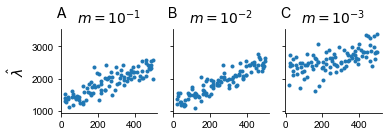

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(5.5, 2), sharex=True, sharey=True)

axs[0].errorbar(rand_jitter(migration_1.ta), migration_1.scale_jt, 
                yerr=2*migration_1.se_scale_jt, linestyle='none', marker='o', markersize=3)

axs[1].errorbar(rand_jitter(migration_2.ta), migration_2.scale_jt, 
                yerr=2*migration_2.se_scale_jt, linestyle='none', marker='o', markersize=3)

axs[2].errorbar(rand_jitter(migration_3.ta), migration_3.scale_jt, 
                yerr=2*migration_3.se_scale_jt, linestyle='none', marker='o', markersize=3)


axs[0].set_title(r'$m = 10^{-1}$', fontsize=14)
axs[1].set_title(r'$m = 10^{-2}$', fontsize=14)
axs[2].set_title(r'$m = 10^{-3}$', fontsize=14)

axs[0].set_ylabel(r'$\hat{\lambda}$', fontsize=14)

debox_all(axs);
label_multipanel(axs, ['A','B','C'], fontsize=14)

plt.savefig(supp_figdir + 'copying_rate_migration.pdf', dpi=300, bbox_inches='tight')